# 0. Install important libraries

In [1]:
%%capture
# Install libraries
!pip install tensorflow keras pillow numpy tqdm underthesea gensim fasttext nltk

# 1. Import important libraries

In [76]:
%%capture
import os
import sys
import string
import fasttext
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pickle import dump, load
from underthesea import word_tokenize
from gensim.utils import simple_preprocess

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences

# from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, add
from keras.initializers import Constant
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu

In [93]:
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201

# 2. Getting and performing data cleaning

In [3]:
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8')
    text = file.read()
    file.close()
    
    return text

In [4]:
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = dict()
    for caption in captions[:-1]:
        img, cap = caption.split('\t')
        if img not in descriptions:
            descriptions[img] = [cap]
        else:
            descriptions[img].append(cap)
    return descriptions

In [5]:
def cleaning_text(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for img, captions in descriptions.items():
        for idx, cap in enumerate(captions):
            desc = cap.replace(' - ', ' ').translate(table)
            desc = ' '.join(simple_preprocess(desc))
            desc = word_tokenize(desc, format='text')
            
            descriptions[img][idx] = desc
    return descriptions

In [6]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(desc.split()) for desc in descriptions[key]]
    
    return vocab

In [7]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, captions in descriptions.items():
        for cap in captions:
            lines.append(key + '\t' + cap)
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding='utf-8')
    file.write(data)
    file.close()

In [70]:
dataset_text = '../input/flickr8k-vi-caps'
dataset_images = '../input/flickr8k/Images'
sample_image = '2423292784_166ee54e0b.jpg'

text_file = dataset_text + '/' + 'captions_vi.txt'

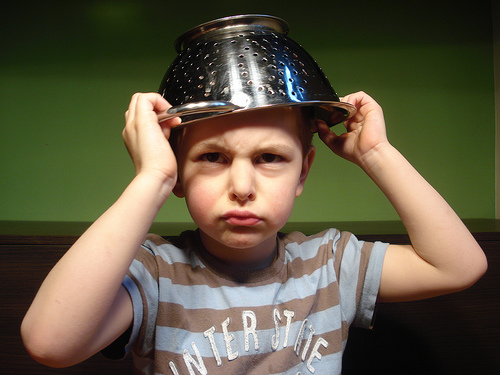

In [83]:
Image.open('/kaggle/input/flickr8k/Images/'+ sample_image)

In [82]:
descriptions = all_img_captions(text_file)
print('Length of descriptions:', len(descriptions))

print('Description before clean text')
descriptions[sample_image]


Length of descriptions: 8000
Description before clean text


['Một cậu bé với một cái chao kim loại trên đầu ',
 ' Một chú hề nhỏ với chiếc chao trên đầu',
 ' Một cậu bé điên có một cái bát trên đầu',
 ' Một cậu bé đội một chiếc chao kim loại trên đầu',
 ' Cậu bé mặc áo sơ mi sọc này đang đặt một cái rây trên đầu']

In [65]:
clean_descriptions = cleaning_text(descriptions)
print('Descriptions after clean text')
clean_descriptions[sample_image]

Descriptions after clean text


['một cậu bé với một cái chao kim_loại trên đầu',
 'một chú hề nhỏ với chiếc chao trên đầu',
 'một cậu bé điên có một cái bát trên đầu',
 'một cậu bé đội một chiếc chao kim_loại trên đầu',
 'cậu bé mặc áo sơ_mi sọc này đang đặt một cái rây trên đầu']

In [66]:
vocab = text_vocabulary(clean_descriptions)
print('Length of vocabuary:', len(vocab))

Length of vocabuary: 6851


In [12]:
save_descriptions(clean_descriptions, 'descriptions.txt')

# 3. Extract feature vector from all images

In [ ]:
# def extract_feature(directory):
#     model = InceptionV3(weights='imagenet')
#     model = Model(model.input, model.layers[-2].output)
    
#     features = dict()
#     for img in tqdm(os.listdir(directory), file=sys.stdout):
#         filename = directory + '/' + img
#         image = load_img(filename, target_size=(299, 299))
#         image = img_to_array(image)
#         image = np.expand_dims(image, axis=0)
#         image = preprocess_input(image)
        
#         feature = model.predict(image, verbose=0)
#         features[img] = feature
#     return features

In [67]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [14]:
def extract_feature(directory):
    # Tải mô hình VGG16 được huấn luyện trên ImageNet
    base_model = VGG16(weights='imagenet')
    # Loại bỏ lớp Dense (lớp phân loại) cuối cùng
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
    
    features = dict()
    for img in tqdm(os.listdir(directory), file=sys.stdout):
        filename = os.path.join(directory, img)
        image = load_img(filename, target_size=(224, 224))  # Kích thước đầu vào của VGG16 là (224, 224)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        feature = model.predict(image, verbose=0)
        features[img] = feature
    return features

In [16]:
# features = extract_feature(dataset_images)
# dump(features, open('features_VGG16_v1.pkl', 'wb'))

In [85]:
feature_path = '/kaggle/input/features-vgg16-v1/features_VGG16_v1.pkl'
features = load(open(feature_path, 'rb'))

In [68]:
# feature_path = '/kaggle/input/features/features.pkl'
# features = load(open(feature_path, 'rb'))

In [ ]:
# features = extract_feature(dataset_images)
# dump(features, open('features_inception_v3.pkl', 'wb'))

In [ ]:
# feature_path = '../input/flickr8k-feature-vector/features_inception_v3.pkl'
# features = load(open(feature_path, 'rb'))

In [86]:
features[sample_image]

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        3.3326447]], dtype=float32)

# 4. Loading dataset for training the model

In [19]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split('\n')
    return photos

In [20]:
def load_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = dict()
    for line in file.split('\n'):
        line = line.split('\t')
        
        if len(line) < 1:
            continue
            
        image, cap = line[0], line[1]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = list()
            desc = 'startseq ' + cap + ' endseq'
            descriptions[image].append(desc)
    return descriptions

In [21]:
def load_features(photos):
    all_features = load(open(feature_path, 'rb'))
    features = {img: all_features[img] for img in photos}
    return features

In [22]:
train_imgs = load_photos(dataset_text + '/' + 'trainImages.txt')
train_descriptions = load_descriptions('descriptions.txt', train_imgs)
train_features = load_features(train_imgs)

test_imgs = load_photos(dataset_text + '/' + 'testImages.txt')
test_descriptions = load_descriptions('descriptions.txt', test_imgs)
test_features = load_features(test_imgs)

# 5. Tokenizing the vocabulary and word embedding

In [23]:
def dict_to_list(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(desc) for desc in descriptions[key]]
    return all_desc

In [24]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    oov_token = 'unk'
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [25]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('# vocabulary:', vocab_size)

# vocabulary: 3299


In [26]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(desc.split()) for desc in desc_list)
max_length = max_length(descriptions)
print('Max length of train set:', max_length)

Max length of train set: 41


In [27]:
def create_embedding_matrix(vocab):
    embedding_index = fasttext.load_model('../input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin')
    
    embedding_dim = 300
    hits = 0
    misses = 0
    vocab_size = len(vocab) + 1
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    
    return embedding_matrix

In [28]:
%%capture --no-stdout
vocab = tokenizer.word_index
embedding_matrix = create_embedding_matrix(vocab)
print("Kích thước của ma trận embedding" ,embedding_matrix.shape)

Converted 3298 words (0 misses)
Kích thước của ma trận embedding (3299, 300)


# 6. Create data generator

In [29]:
''' Hàm này tạo ra một generator để tạo dữ liệu cho quá trình đào tạomô hình mạng neural
network,trong đó mỗi batch bao gồm các đặc trưng hình ảnh, các chuỗi từ (đã được padding),
và các vector one-hot encoding cho từ tiếp theo trong mỗi mô tả.

'''
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key, captions in descriptions.items():
            n += 1
            feature = features[key][0]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Chuyển đầu ra thành one-hot encoding với kích thươcs
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [87]:
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length, vocab_size, 32))
a.shape, b.shape, c.shape

((2356, 4096), (2356, 41), (2356, 3299))

# 7. Defining the CNN-RNN model

In [31]:
# def define_model(vocab_size, max_length):
#     embedding_dim = 300
#     inputs1 = Input(shape=(4096,))
#     fe1 = Dropout(0.5)(inputs1)
#     fe2 = Dense(256, activation='relu')(fe1)

#     inputs2 = Input(shape=(max_length,))
#     se1 = Embedding(
#         vocab_size,
#         embedding_dim,
#         embeddings_initializer=Constant(embedding_matrix),
#         mask_zero=True,
#         trainable=False,
#     )(inputs2)
#     se2 = Dropout(0.5)(se1)
#     se3 = Bidirectional(LSTM(128))(se2)

#     decoder1 = add([fe2, se3])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     outputs = Dense(vocab_size, activation='softmax')(decoder2)

#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001))

#     print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)

#     return model

In [32]:
def define_model(vocab_size, max_length):
    embedding_dim = 300
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.3)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(
        vocab_size, #1149
        embedding_dim, #300
        embeddings_initializer=Constant(embedding_matrix),
        mask_zero=True,
        trainable=False,
    )(inputs2)
    se2 = Dropout(0.3)(se1)
    se3 = Bidirectional(LSTM(128))(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001))

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [33]:
model = define_model(vocab_size, max_length)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 300)      989700      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

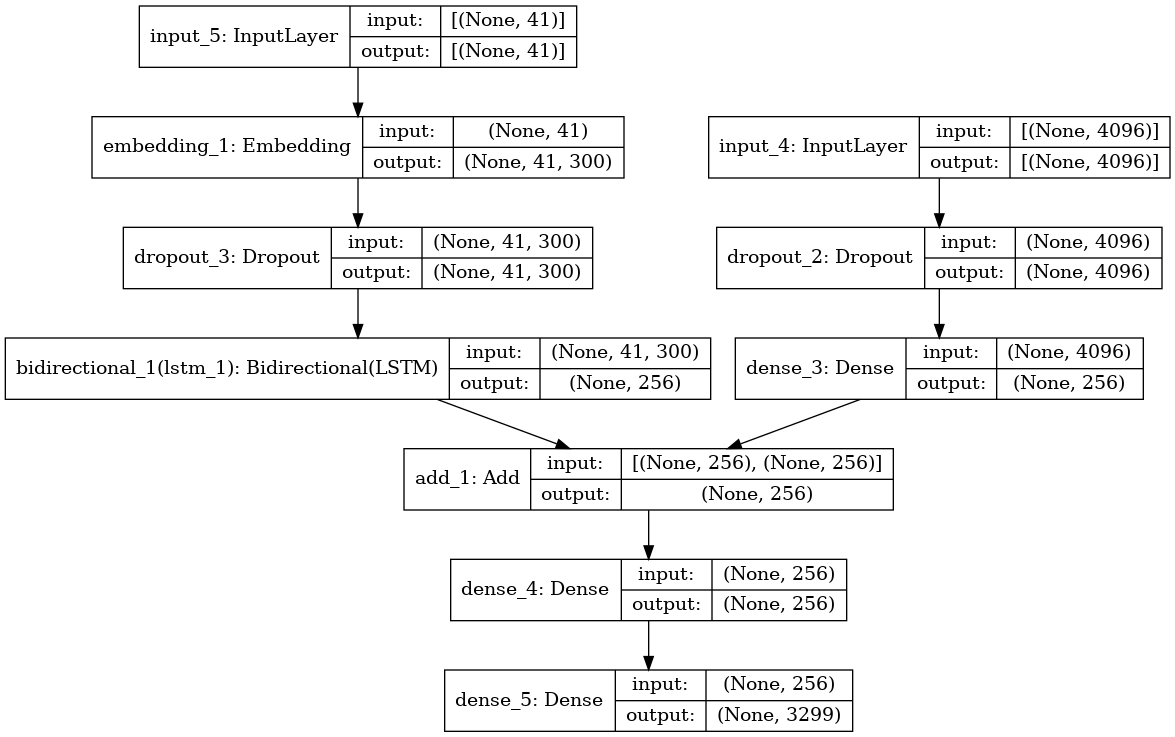

In [35]:
plot_model(model, show_shapes=True)

# 8. Training the model

In [37]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 20
batch_size = 32
steps = len(train_imgs) // batch_size

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 3299
Description Length:  41
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 41, 300)      989700      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 4096)         0           input_8[0][0]      

In [38]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save("best_model.h5")

187/187 [==============================] - 38s 203ms/step - loss: 3.0743


# 9. Generate captions for the image

In [41]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [42]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([image, seq], verbose=0)
        pred_ids = np.argmax(yhat)
        word = idx_to_word(pred_ids, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [43]:
# model = load_model('./best_model.h5')
# actual, predicted = list(), list()

# for image in tqdm(test_imgs):
#     captions = test_descriptions[image]
#     actual_captions = [caption.split() for caption in captions]

#     y_pred = predict_caption(model, test_features[image], tokenizer, max_length)
#     y_pred = y_pred.split()

#     actual.append(actual_captions)
#     predicted.append(y_pred)

# # BLEU score
# print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

# 10. Visualize the results

In [44]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_path = os.path.join(dataset_images, image_name)
    image = Image.open(image_path)
    descriptions = load_descriptions('./descriptions.txt', train_imgs + test_imgs)
    captions = descriptions[image_name]
    print('-' * 20 + 'Actual' + '-' * 20)
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('-' * 20 + 'Predicted' + '-' * 20)
    print(y_pred)
    plt.imshow(image)

--------------------Actual--------------------
startseq một người đàn_ông mặc trang_phục màu vàng đua xe_đạp giữa thiên_nhiên hoang_dã endseq
startseq biker với mũ_bảo_hiểm màu xanh đi dọc theo đường_mòn rỉ sét endseq
startseq người đi xe_đạp khi xuống_dốc trên một con dốc cao endseq
startseq người đàn_ông đội mũ_bảo_hiểm trên một chiếc xe_đạp khi đi trên con đường_mòn đá endseq
startseq người đi xe_đạp leo núi đang xuống đồi trên con đường_mòn trong rừng endseq
--------------------Predicted--------------------
startseq một người đàn ông đi xe đạp leo núi endseq


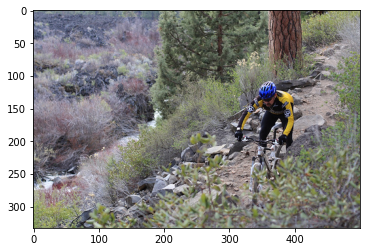

In [48]:
from random import sample

image_name = sample(train_imgs, 1)[0]
generate_caption(image_name)

--------------------Actual--------------------
startseq một nhóm đàn_ông đang đứng xung_quanh trong một trò_chơi thể_thao trong công_viên endseq
startseq đàn_ông trong công_viên endseq
startseq đàn_ông chơi bóng_đá trên một cánh đồng endseq
startseq đàn_ông đứng trên một cánh đồng_cỏ với những cái cây phía sau endseq
startseq chín người đàn_ông đang chơi một trò_chơi trong công_viên áo sơ_mi so với da endseq
--------------------Predicted--------------------
startseq một người đàn ông chơi bóng đá endseq


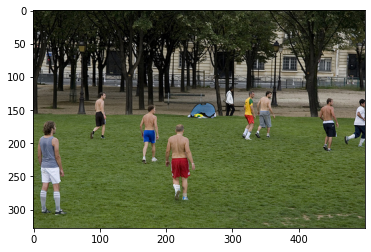

In [50]:
image_name = sample(train_imgs, 1)[0]
generate_caption(image_name)

--------------------Actual--------------------
startseq hai chú chó đang bơi qua vùng nước sâu trong phạm_vi gần nhau endseq
startseq hai con chó trắng đang bơi endseq
startseq hai con chó trắng bơi mặt_đối_mặt trong nước râm mát endseq
startseq hai con chó trắng bơi trong đại_dương endseq
startseq con chó trắng trong nước endseq
--------------------Predicted--------------------
startseq một con chó đang đang đang trong nước endseq


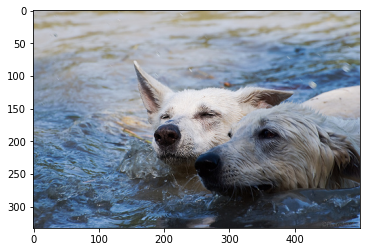

In [88]:
image_name = sample(train_imgs, 1)[0]
generate_caption(image_name)

--------------------Actual--------------------
startseq một đứa trẻ nhảy từ cầu trượt xuống hồ bơi endseq
startseq một cô gái đi xuống cầu trượt màu vàng xuống hồ bơi endseq
startseq một cô gái đang nhảy xuống một hồ bơi với hai đường trượt phía sau endseq
startseq một bé gái nhảy từ chiếc thang màu vàng xuống bể bơi endseq
startseq một cô gái trẻ trong bộ_đồ tắm màu xanh nhảy ra khỏi một chiếc cầu trượt màu vàng xuống nước endseq
--------------------Predicted--------------------
startseq một cậu bé mặc áo xanh đang nhảy xuống hồ bơi endseq


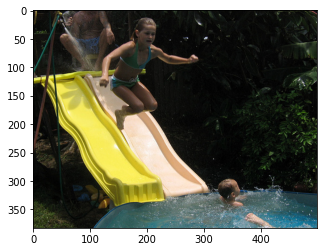

In [54]:
image_name = sample(train_imgs, 1)[0]
generate_caption(image_name)

In [ ]:
generate_caption()